In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
import yfinance as yf
import myfuncs

# 시각화 관련
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [3]:
ticker = 'SCHD'

In [27]:
df = yf.download(ticker, ignore_tz = True, auto_adjust = True)

[*********************100%%**********************]  1 of 1 completed


In [28]:
df = df[['Close']]

In [29]:
df

,Close
Date,
2011-10-20,6.820252
2011-10-21,6.954036
2011-10-24,6.992260
2011-10-25,6.877587
2011-10-26,6.948575
...,...
2024-12-30,27.230000
2024-12-31,27.320000
2025-01-02,27.260000


## Visualization

In [30]:
def plot_stock_trend(data, title="Stock Price Trend", figsize=(10, 6)):
    """
    주가 트렌드를 시각화하는 함수

    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        title (str): 그래프 제목
        figsize (tuple): 그래프 크기
    
    Returns:
        None
    """
    if 'Close' not in data.columns:
        raise ValueError("DataFrame must contain a 'Close' column for closing prices.")
    
    # 그래프 설정
    plt.figure(figsize=figsize)
    plt.plot(data.index, data['Close'], label='Close Price', linewidth=2)

    # 그래프 스타일
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price (USD)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # 그래프 출력
    plt.show()

# 사용 예제
# SCHD 종가 데이터가 담긴 DataFrame
# 예시: df = pd.read_csv("SCHD_data.csv", index_col="Date", parse_dates=True)

# plot_stock_trend(df, title="SCHD Closing Price Trend")


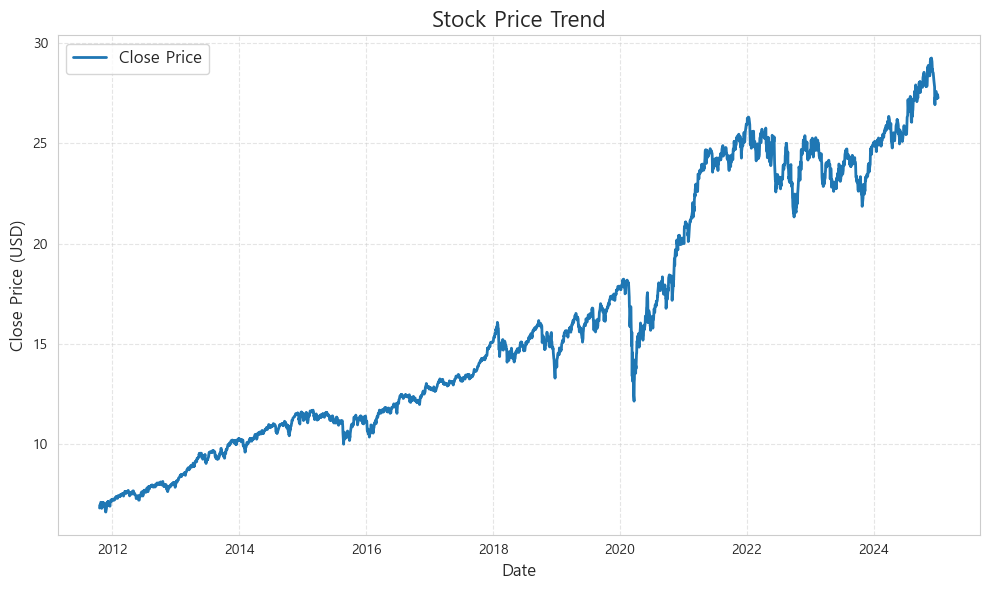

In [31]:
plot_stock_trend(df)

In [33]:
def analyze_volatility(data, window=20, figsize=(12, 8)):
    """
    주가 변동성을 분석하고 시각화하는 함수
    
    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        window (int): 이동 변동성을 계산할 윈도우 크기 (일 수)
        figsize (tuple): 그래프 크기
    
    Returns:
        pd.DataFrame: 변동성을 포함한 새로운 데이터프레임
    """
    if 'Close' not in data.columns:
        raise ValueError("DataFrame must contain a 'Close' column for closing prices.")
    
    # 수익률 계산 (로그 수익률)
    data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # 이동 표준편차 (변동성) 계산
    data['Rolling Volatility'] = data['Log Returns'].rolling(window=window).std()
    
    # 시각화
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # 1. 로그 수익률 히스토그램
    axes[0].hist(data['Log Returns'].dropna(), bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[0].set_title('Log Returns Distribution', fontsize=14)
    axes[0].set_xlabel('Log Returns', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # 2. 이동 변동성 그래프
    axes[1].plot(data.index, data['Rolling Volatility'], label=f'{window}-Day Rolling Volatility', color='orange', linewidth=2)
    axes[1].set_title(f'{window}-Day Rolling Volatility', fontsize=14)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Volatility', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    axes[1].legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return data

# 사용 예제
# SCHD 종가 데이터가 담긴 DataFrame
# 예시: df = pd.read_csv("SCHD_data.csv", index_col="Date", parse_dates=True)

# 분석 실행
# result_df = analyze_volatility(df, window=20)


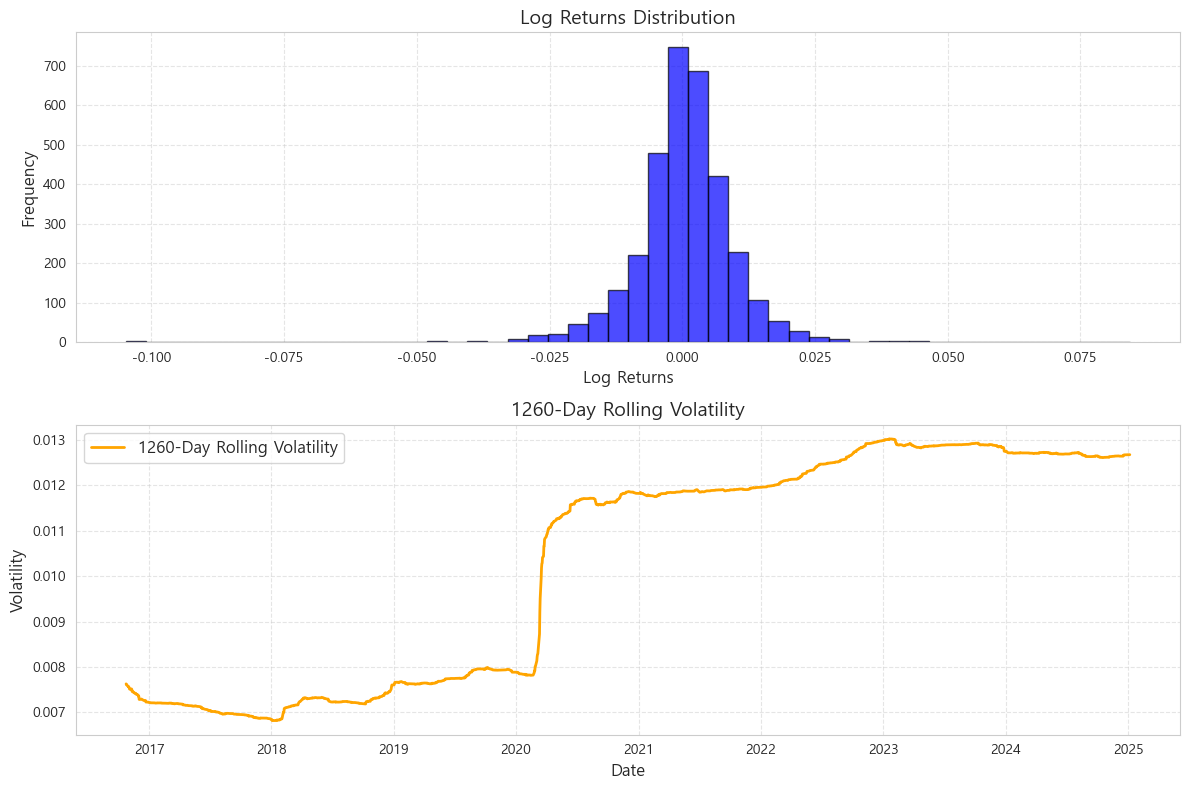

,Close,Log Returns,Rolling Volatility
Date,,,
2011-10-20,6.820252,NaN,NaN
2011-10-21,6.954036,0.019426,NaN
2011-10-24,6.992260,0.005482,NaN
2011-10-25,6.877587,-0.016536,NaN
2011-10-26,6.948575,0.010269,NaN
...,...,...,...
2024-12-30,27.230000,-0.008775,0.012677
2024-12-31,27.320000,0.003300,0.012678
2025-01-02,27.260000,-0.002199,0.012676


In [36]:
analyze_volatility(df, window=252*5)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_mdd(data, title="Maximum Drawdown (MDD)", figsize=(10, 6)):
    """
    MDD를 계산하고 시각화하는 함수
    
    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        title (str): 그래프 제목
        figsize (tuple): 그래프 크기
    
    Returns:
        float: MDD 값
    """
    if 'Close' not in data.columns:
        raise ValueError("DataFrame must contain a 'Close' column for closing prices.")
    
    # 누적 최대값 계산
    data['Cumulative Max'] = data['Close'].cummax()
    
    # Drawdown 계산
    data['Drawdown'] = (data['Close'] - data['Cumulative Max']) / data['Cumulative Max']
    
    # MDD 계산
    mdd = data['Drawdown'].min()
    
    # 시각화
    plt.figure(figsize=figsize)
    plt.plot(data.index, data['Drawdown'], label='Drawdown', color='blue', linewidth=2)
    plt.axhline(y=mdd, color='red', linestyle='--', label=f'MDD: {mdd:.2%}')
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Drawdown", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return mdd

# 사용 예제
# SCHD 종가 데이터가 담긴 DataFrame
# 예시: df = pd.read_csv("SCHD_data.csv", index_col="Date", parse_dates=True)

# MDD 시각화 실행
# mdd_value = plot_mdd(df, title="SCHD Maximum Drawdown")
# print(f"MDD: {mdd_value:.2%}")


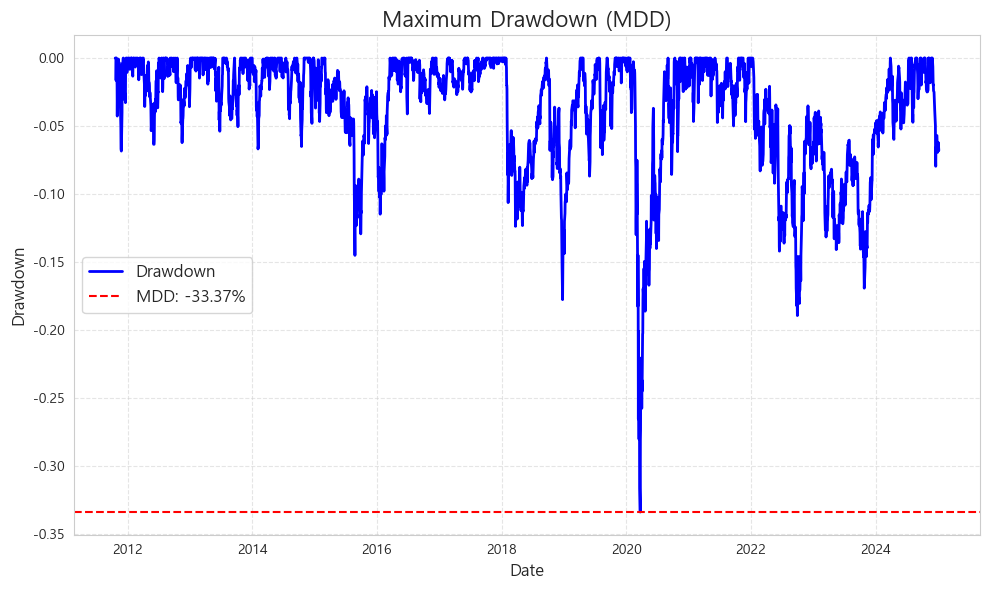

In [41]:
mdd = plot_mdd(df)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_ttr(data, title="Time to Recovery (TTR)", figsize=(12, 6)):
    """
    TTR(Time to Recovery)을 계산하고 시각화하는 함수
    
    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        title (str): 그래프 제목
        figsize (tuple): 그래프 크기
    
    Returns:
        pd.DataFrame: TTR 데이터를 포함한 새로운 데이터프레임
    """
    if 'Close' not in data.columns:
        raise ValueError("DataFrame must contain a 'Close' column for closing prices.")
    
    # 누적 최대값 계산
    data['Cumulative Max'] = data['Close'].cummax()
    
    # Drawdown 계산
    data['Drawdown'] = (data['Close'] - data['Cumulative Max']) / data['Cumulative Max']
    
    # 회복 기간 계산
    ttr = []
    last_high_idx = None
    for i in range(len(data)):
        if data['Close'].iloc[i] == data['Cumulative Max'].iloc[i]:  # 최고점으로 회복한 경우
            last_high_idx = i
            ttr.append(0)  # 회복한 날은 0일
        elif last_high_idx is not None:  # 아직 회복 중인 경우
            ttr.append(i - last_high_idx)
        else:  # 시작 전 (초기 데이터)
            ttr.append(0)
    
    data['TTR'] = ttr

    # 시각화
    plt.figure(figsize=figsize)
    plt.plot(data.index, data['TTR'], label='Time to Recovery (TTR)', color='blue', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Days to Recovery", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return data

# 사용 예제
# SCHD 종가 데이터가 담긴 DataFrame
# 예시: df = pd.read_csv("SCHD_data.csv", index_col="Date", parse_dates=True)

# TTR 시각화 실행
# result_df = plot_ttr(df, title="SCHD Time to Recovery")
# print(result_df[['Close', 'TTR']].tail())


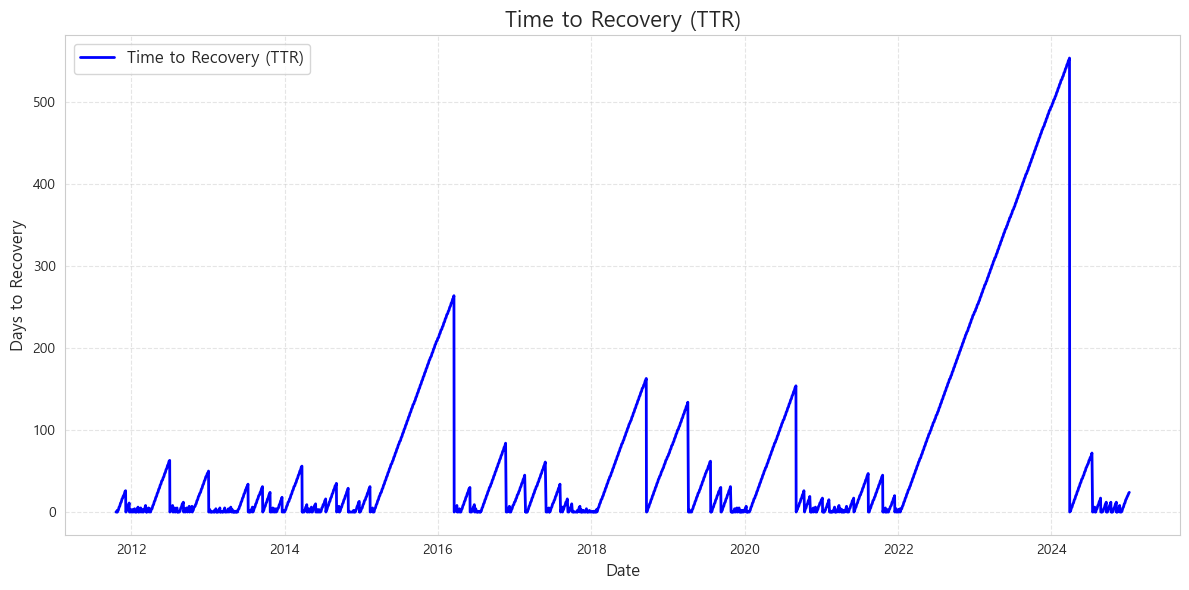

In [45]:
ttr = plot_ttr(df)

In [47]:
ttr['TTR'].max()

554

In [61]:
tickers = ["QQQ", "SCHD"]

# 여러 티커의 데이터 다운로드
dataset = yf.download(tickers, auto_adjust=True)
dataset = dataset['Close'].dropna()

[*********************100%%**********************]  2 of 2 completed


In [63]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_multi_stock_trend(data, columns, title="Stock Price Trend Comparison", figsize=(12, 6)):
    """
    여러 종목의 주가 트렌드를 시각화하는 함수

    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        columns (list): 시각화할 종목의 열 이름 리스트 (예: ['QQQ', 'SCHD'])
        title (str): 그래프 제목
        figsize (tuple): 그래프 크기
    
    Returns:
        None
    """
    # 데이터 유효성 검사
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    # 그래프 설정
    plt.figure(figsize=figsize)
    
    # 각 종목의 주가 그래프 그리기
    for col in columns:
        plt.plot(data.index, data[col], label=col, linewidth=2)
    
    # 그래프 스타일
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price (USD)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # 그래프 출력
    plt.show()

# 사용 예제
# 두 종목의 종가 데이터를 포함한 DataFrame
# 예시:
# df = pd.DataFrame({
#     'Date': ['2024-01-01', '2024-01-02', '2024-01-03'],
#     'QQQ': [300, 305, 310],
#     'SCHD': [75, 76, 77]
# })
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# plot_multi_stock_trend(df, columns=['QQQ', 'SCHD'], title="QQQ vs SCHD Trend")


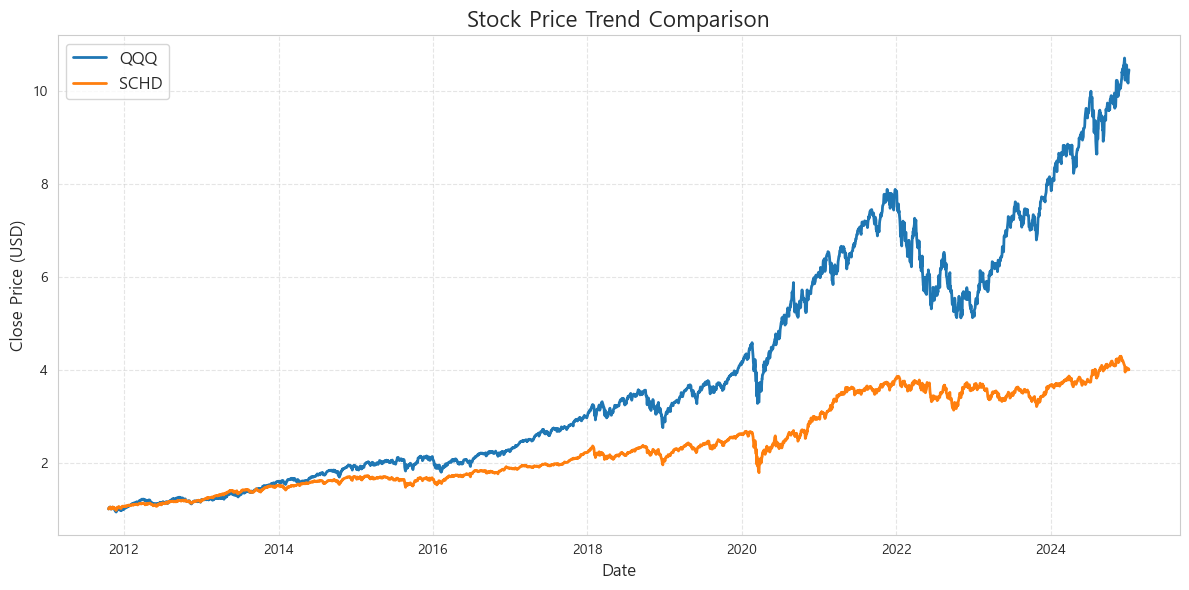

In [67]:
plot_multi_stock_trend(dataset/dataset.iloc[0], dataset.columns)

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_volatility_histogram(data, columns, bins=50, title="Volatility Histogram", figsize=(12, 6)):
    """
    여러 종목의 변동성을 히스토그램으로 시각화하는 함수

    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        columns (list): 변동성을 분석할 종목의 열 이름 리스트 (예: ['QQQ', 'SCHD'])
        bins (int): 히스토그램의 빈 개수
        title (str): 그래프 제목
        figsize (tuple): 그래프 크기
    
    Returns:
        pd.DataFrame: 각 종목의 로그 수익률을 포함한 데이터프레임
    """
    # 데이터 유효성 검사
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    # 로그 수익률 계산
    log_returns = pd.DataFrame()
    for col in columns:
        log_returns[col] = np.log(data[col] / data[col].shift(1))
    
    # 시각화
    plt.figure(figsize=figsize)
    
    for col in columns:
        plt.hist(log_returns[col].dropna(), bins=bins, alpha=0.5, label=col, edgecolor='black')
    
    # 그래프 스타일
    plt.title(title, fontsize=16)
    plt.xlabel("Log Returns", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # 그래프 출력
    plt.show()
    
    return log_returns

# 사용 예제
# 두 종목의 종가 데이터를 포함한 DataFrame
# 예시:
# df = pd.DataFrame({
#     'Date': ['2024-01-01', '2024-01-02', '2024-01-03'],
#     'QQQ': [300,


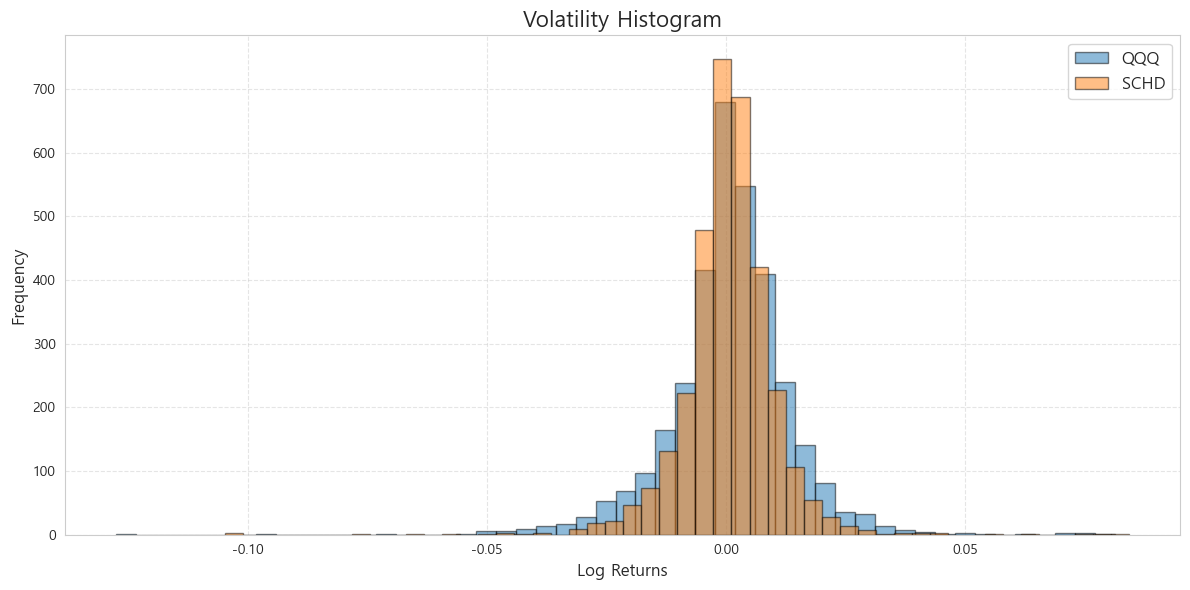

,QQQ,SCHD
Date,,
2011-10-20,NaN,NaN
2011-10-21,0.012468,0.019426
2011-10-24,0.020556,0.005482
2011-10-25,-0.019858,-0.016536
2011-10-26,-0.001221,0.010268
...,...,...
2024-12-30,-0.013389,-0.008775
2024-12-31,-0.008531,0.003300
2025-01-02,-0.001958,-0.002199


In [72]:
plot_volatility_histogram(dataset/dataset.iloc[0], dataset.columns)

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_mdd(data, columns, title="Maximum Drawdown (MDD)", figsize=(12, 6)):
    """
    여러 종목의 MDD를 계산하고 시각화하는 함수
    
    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        columns (list): MDD를 계산할 종목의 열 이름 리스트 (예: ['QQQ', 'SCHD'])
        title (str): 그래프 제목
        figsize (tuple): 그래프 크기
    
    Returns:
        pd.DataFrame: 각 종목의 Drawdown 및 MDD를 포함한 데이터프레임
    """
    # 데이터 유효성 검사
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    drawdowns = pd.DataFrame(index=data.index)
    
    # MDD 계산
    for col in columns:
        # 누적 최대값 계산
        cumulative_max = data[col].cummax()
        # Drawdown 계산
        drawdown = (data[col] - cumulative_max) / cumulative_max
        drawdowns[col] = drawdown

    # 시각화
    plt.figure(figsize=figsize)
    
    for col in columns:
        plt.plot(drawdowns.index, drawdowns[col], label=f'{col} Drawdown', linewidth=2)
        # MDD 표시
        mdd = drawdowns[col].min()
        plt.axhline(y=mdd, linestyle='--', label=f'{col} MDD: {mdd:.2%}', alpha=0.7)
    
    # 그래프 스타일
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Drawdown", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # 그래프 출력
    plt.show()
    
    return drawdowns

# 사용 예제
# 두 종목의 종가 데이터를 포함한 DataFrame
# 예시:
# df = pd.DataFrame({
#     'Date': ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04'],
#     'QQQ': [300, 305, 290, 310],
#     'SCHD': [75, 76, 74, 77]
# })
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# plot_mdd(df, columns=['QQQ', 'SCHD'], title="QQQ vs SCHD Maximum Drawdown")


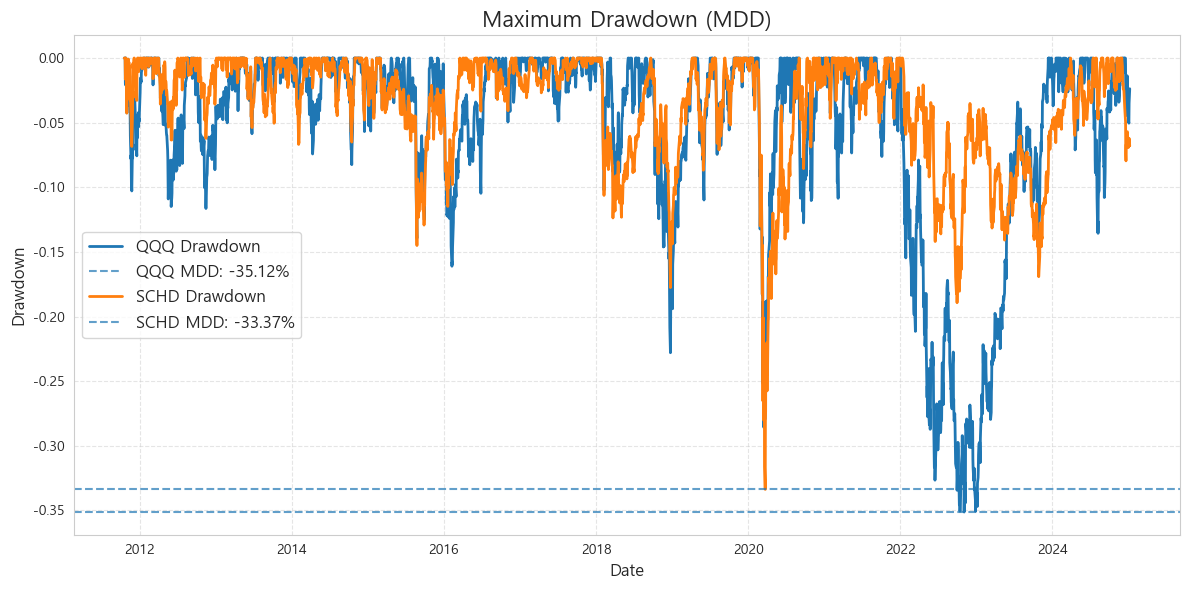

In [74]:
mdd_df = plot_mdd(dataset, dataset.columns)

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_ttr(data, columns, title="Time to Recovery (TTR)", figsize=(12, 6)):
    """
    여러 종목의 회복 기간(TTR)을 계산하고 시각화하는 함수
    
    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임 (DateTimeIndex 필요)
        columns (list): TTR을 계산할 종목의 열 이름 리스트 (예: ['QQQ', 'SCHD'])
        title (str): 그래프 제목
        figsize (tuple): 그래프 크기
    
    Returns:
        pd.DataFrame: 각 종목의 TTR을 포함한 데이터프레임
    """
    # 데이터 유효성 검사
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    ttr_data = pd.DataFrame(index=data.index)
    
    for col in columns:
        # 누적 최대값 계산
        cumulative_max = data[col].cummax()
        # Drawdown 여부 계산
        is_drawdown = data[col] < cumulative_max
        
        # 회복 기간 계산
        ttr = []
        recovery_start_idx = None
        for i in range(len(data)):
            if not is_drawdown.iloc[i]:  # 회복된 경우
                recovery_start_idx = i
                ttr.append(0)  # 회복한 날은 TTR = 0
            elif recovery_start_idx is not None:  # 회복 중인 경우
                ttr.append(i - recovery_start_idx)
            else:  # 시작 데이터 또는 초기 드로우다운 발생
                ttr.append(0)
        
        ttr_data[col] = ttr

    # 시각화
    plt.figure(figsize=figsize)
    for col in columns:
        plt.plot(ttr_data.index, ttr_data[col], label=f'{col} TTR', linewidth=2)
    
    # 그래프 스타일
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Days to Recovery", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # 그래프 출력
    plt.show()
    
    return ttr_data

# 사용 예제
# 두 종목의 종가 데이터를 포함한 DataFrame
# 예시:
# df = pd.DataFrame({


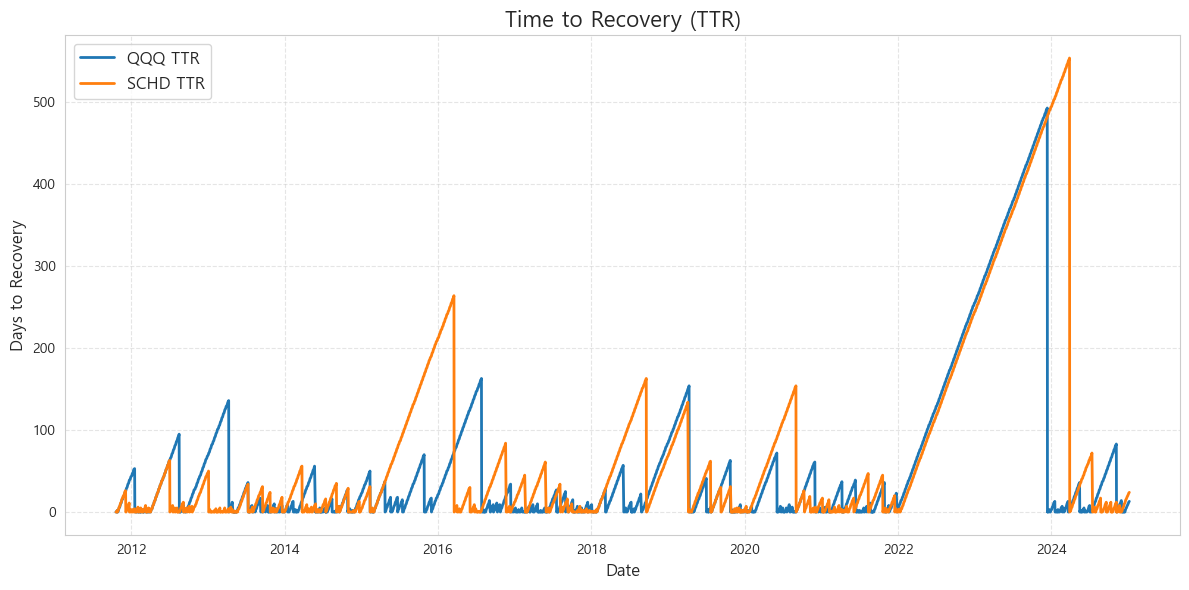

In [77]:
ttr_df = plot_ttr(dataset, dataset.columns)

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(data, columns, title="Correlation Heatmap", figsize=(8, 6), annot=True):
    """
    두 자산의 상관분석 결과를 히트맵으로 시각화하는 함수
    
    Parameters:
        data (pd.DataFrame): 종가 데이터를 포함한 데이터프레임
        columns (list): 상관분석을 수행할 종목의 열 이름 리스트 (예: ['QQQ', 'SCHD'])
        title (str): 히트맵 제목
        figsize (tuple): 히트맵 크기
        annot (bool): 상관계수 값 표시 여부
    
    Returns:
        pd.DataFrame: 상관계수 행렬
    """
    # 데이터 유효성 검사
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    # 상관계수 계산
    correlation_matrix = data[columns].corr()
    
    # 히트맵 시각화
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=annot, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    # 히트맵 출력
    plt.show()
    
    return correlation_matrix

# 사용 예제
# 두 종목의 종가 데이터를 포함한 DataFrame
# 예시:
# df = pd.DataFrame({
#     'Date': ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04'],
#     'QQQ': [300, 305, 310, 315],
#     'SCHD': [75, 76, 77, 78]
# })
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# plot_correlation_heatmap(df, columns=['QQQ', 'SCHD'], title="QQQ vs SCHD Correlation")


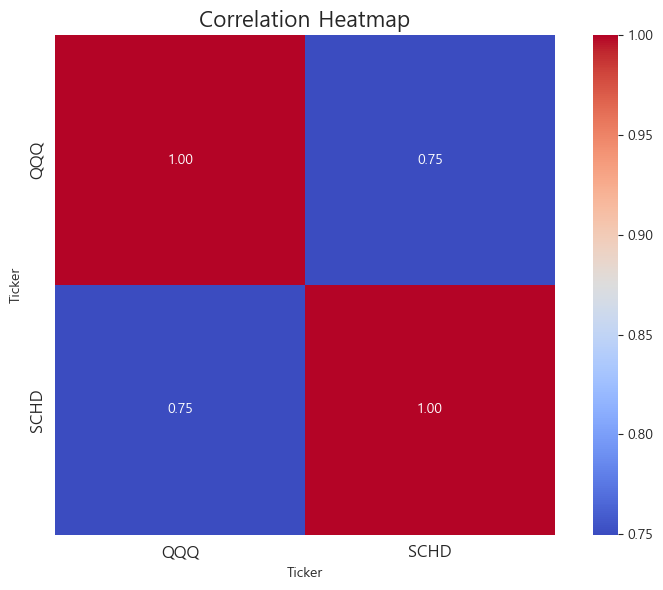

Ticker,QQQ,SCHD
Ticker,,
QQQ,1.000000,0.749713
SCHD,0.749713,1.000000


In [80]:
plot_correlation_heatmap(dataset.pct_change(), dataset.columns)